## [NYCDSA Capstone Project] 
# Women's Softball League Power Ranking Estimate

<br>
Koeun Lim (koeunlim@alum.mit.edu)<br>
Kevin Haghi (kevin.haghi@gmail.com)<br>


# Step 5. Modeling 1 - RPI Prediction

---
## Project Description



### Project Outline
- Step 1. Web scraping
- Step 2. Clean data
- Step 3. EDA
- Step 4. Imputation & PCA
- Step 5. Modeling (1) RPI prediction based on stats

In [97]:
import pickle 

import pandas as pd
import numpy as np
import seaborn as sn
import xgboost as xgb
import sklearn.model_selection as ms

from datetime import datetime
from scipy import stats

from matplotlib import pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

In [82]:
%store -r y_RPI
%store -r y_RPI_2019
%store -r X_famd
%store -r X_famd_2019
%store -r X_College
%store -r X_College_2019

In [83]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [84]:
y = y_RPI
X = X_famd.copy()
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
297,2.170850,-0.027647,0.127369,1.219246,0.368641,-0.196787,-0.130418,-0.171609,-0.352457,0.058697,-0.383129,0.073038,1.005647,0.595547,0.468127,-0.074023,-0.904480,0.720769,-0.207444,-0.485857,-0.214408,-0.676500,-0.153969,-0.128498,-0.310688,-0.043215,0.134537,0.032437,-0.287246,0.018377,0.098459,-0.270373,-0.335707,-0.448651,0.572197,0.410523,-0.068122,-0.046195,0.043469,-0.303446,-0.294815,-0.532836,0.235490,-0.178836,-0.052232,-0.010824,0.022264
298,2.494396,-0.349768,-0.344156,-0.027539,-0.393484,-0.083979,-0.645833,1.197497,-0.807566,0.329022,-0.167865,-0.454194,0.645177,0.477687,-0.396526,0.407270,0.098008,-0.408822,0.217627,0.550522,0.343296,0.310762,-0.242690,0.102283,0.435957,0.295430,-0.019137,-0.204928,0.257748,-0.033217,-0.076521,0.637219,-0.116861,-0.095138,0.027686,0.371716,0.534058,0.189141,-0.112994,-0.270728,-0.008564,-0.010155,0.190365,0.201579,-0.095771,-0.000673,0.000086
299,2.457301,-0.283095,-0.206933,-0.126478,-0.400174,0.167933,-0.737496,1.330876,-0.816391,0.307917,-0.206095,-0.494546,0.657509,0.443358,-0.414156,0.395289,0.065043,-0.445311,0.208540,0.538905,0.336216,0.306693,-0.206007,0.090296,0.440320,0.308226,-0.028989,-0.224333,0.258356,-0.020713,-0.057799,0.639894,-0.185656,-0.244586,-0.110804,-0.140564,0.020098,0.134771,-0.115916,-0.294089,0.135937,0.302643,0.244900,0.082033,-0.046263,-0.009489,-0.004715
300,2.908420,-0.812397,-0.120084,-0.298639,0.672517,0.069064,0.087966,0.139732,0.310211,0.063894,0.114614,-0.022350,0.665968,0.105203,-0.150634,-0.645803,0.153987,-0.398356,0.099389,0.377348,0.142229,0.649320,0.818685,0.093924,-0.460005,-1.153012,-0.532278,1.535312,-0.473104,0.152722,-0.480115,0.391411,-0.465212,0.441163,-0.201934,0.192078,0.115855,0.443823,-0.596109,-0.125310,0.085299,0.075666,0.421896,0.160937,0.093301,-0.004882,0.025164
301,2.452516,-0.725179,-0.179109,-0.183864,-0.318930,0.200328,-0.708240,1.214912,-0.771176,0.350310,-0.168707,-0.451476,0.672903,0.490794,-0.377889,0.386218,0.058440,-0.463347,0.218717,0.552809,0.343879,0.272640,-0.235689,0.091781,0.435474,0.315789,-0.024178,-0.214399,0.252061,-0.025570,-0.038579,0.615931,-0.221270,-0.344349,-0.016926,0.053174,0.357887,-0.270456,-0.212351,-0.516283,-0.072864,-0.125879,0.404643,0.165810,-0.036130,0.006442,-0.008450


In [85]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train = X
y_train = y
X_test = X_famd_2019
y_test = y_RPI_2019

In [86]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [1, 2, 5, 10],
    'gamma': [0, 1, 2, 5],
    'reg_alpha': [0],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'random_state' :[1]
}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',nthread= -1,gpu_id=-1)

In [87]:
folds = 5
param_comb = 100

random_search1 = RandomizedSearchCV(
    xg_reg, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    cv=folds, 
    verbose=4
)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search1.fit(X_train,y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits

 Time taken: 0 hours 6 minutes and 42.78 seconds.


In [88]:
print('\n All results:')
print(random_search1.cv_results_)
print('\n\n Best estimator:')
print(random_search1.best_estimator_)
print('\n\n Best rmse %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(-random_search1.best_score_)
print('\n\n Best R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y, random_search1.predict(X)))
print('\n\n Best hyperparameters:')
print(random_search1.best_params_)
results1 = pd.DataFrame(random_search1.cv_results_).sort_values('rank_test_score', ascending=True)
results1.to_csv('XGBoost/xgb-random-grid-search-results-train_famd02.csv', index=False)


 All results:
{'mean_fit_time': array([1.62634063, 0.9902204 , 6.28567867, 1.87716479, 1.48562064,
       4.19181838, 3.00376115, 1.00267639, 1.28576708, 1.49548054,
       1.49429398, 2.41334119, 3.960144  , 1.88765979, 3.80021281,
       3.963592  , 1.1877142 , 4.44158039, 2.69882069, 1.73109522,
       3.37093053, 5.17264261, 1.18221154, 1.15170026, 3.57678084,
       4.49845109, 4.59946599, 1.24811549, 4.57744627, 1.63226628,
       3.26497722, 3.04332995, 1.50715933, 1.28622603, 4.18072457,
       4.59279737, 6.2152698 , 3.26513243, 4.88244443, 6.09000788,
       2.66898346, 1.45919003, 7.56084104, 2.87968388, 5.78690443,
       6.12298179, 2.78405986, 1.34983354, 3.06899595, 1.48931308,
       2.85760875, 1.88617458, 1.00657892, 3.53578362, 2.3179122 ,
       4.67489967, 1.38451753, 1.98575335, 3.86604486, 2.03417687,
       3.6241982 , 4.62024455, 3.10798717, 2.63461561, 4.81585135,
       5.50931735, 1.0215426 , 1.14639502, 2.58711834, 5.99042225,
       4.29325094, 3.34475608



Best Train R_squared 5-fold search with 100 parameter combinations:
0.9642988751499263


Best Test R_squared 5-fold search with 100 parameter combinations:
0.8512302803668258


Best R_squared 5-fold search with 100 parameter combinations:
0.9642988751499263


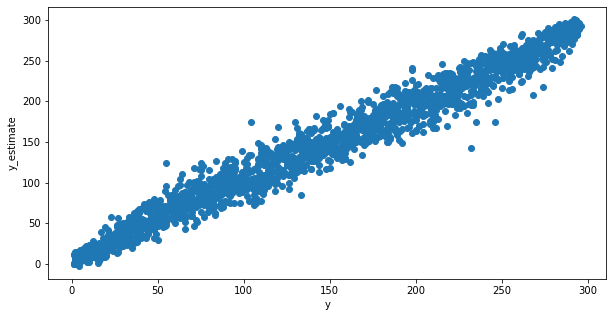

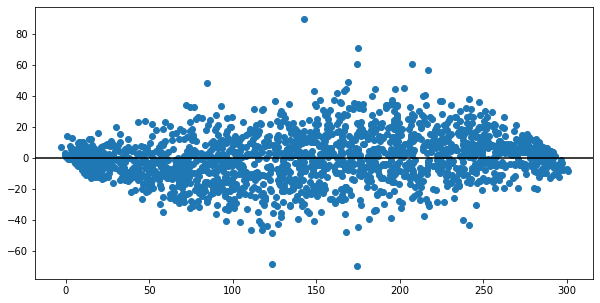

In [89]:
print('\n\nBest Train R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_train, random_search1.predict(X_train)))
print('\n\nBest Test R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_test, random_search1.predict(X_test)))
print('\n\nBest R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y, random_search1.predict(X)))

plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(y,random_search1.predict(X))
plt.xlabel('y')
plt.ylabel('y_estimate')
plt.show()

plt.scatter(random_search1.predict(X),y-random_search1.predict(X))
plt.axhline(color='black')
plt.show()

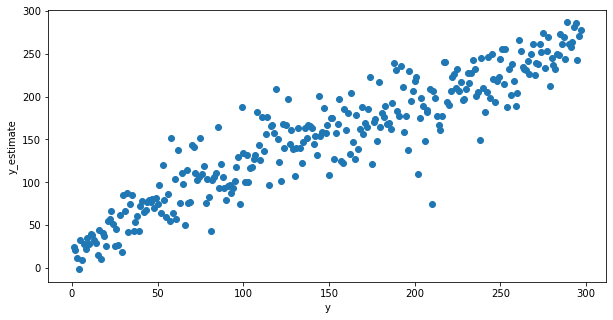

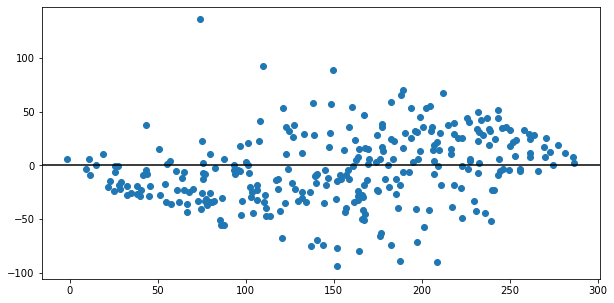

In [100]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(y_test,random_search1.predict(X_test))
plt.xlabel('y')
plt.ylabel('y_estimate')
plt.show()

plt.scatter(random_search1.predict(X_test),y_test-random_search1.predict(X_test))
plt.axhline(color='black')
plt.show()

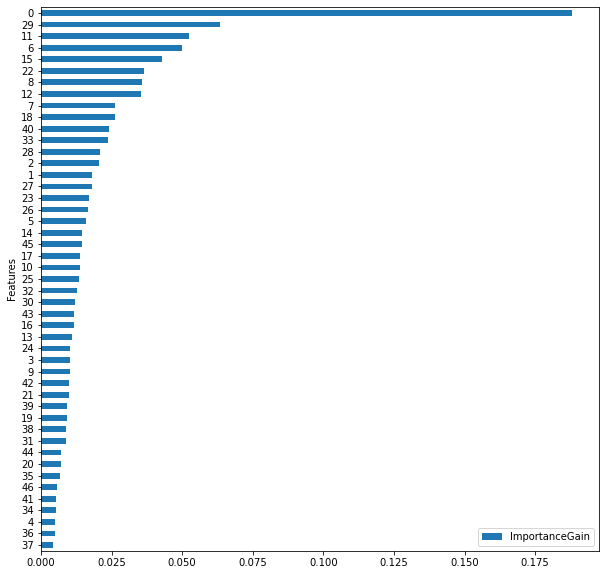

,Features,ImportanceGain,CummulativeGain
0,0,0.188187,0.188187
29,29,0.063547,0.251734
11,11,0.052493,0.304227
6,6,0.049941,0.354168
15,15,0.042893,0.397062
22,22,0.036331,0.433393
8,8,0.035956,0.469349
12,12,0.035260,0.504608
7,7,0.026186,0.530794
18,18,0.026163,0.556957


In [90]:
feature_importance1 = pd.DataFrame(X.columns)
feature_importance1.columns = ['Features']
feature_importance1['ImportanceGain'] = random_search1.best_estimator_.feature_importances_
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1['CummulativeGain'] = feature_importance1.ImportanceGain.cumsum()

plt.rcParams['figure.figsize'] = (10, 10)
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1.sort_values('ImportanceGain', ascending=True).plot(x='Features',y='ImportanceGain',kind='barh')
plt.show()

feature_importance1

### Bootstrap resampling to obtain the predicted RPI distribution

In [91]:
print(random_search1.best_estimator_)
print(random_search1.best_params_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, nthread=-1, num_parallel_tree=1,
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)
{'subsample': 0.6, 'reg_alpha': 0, 'random_state': 1, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 0.6}


In [92]:
best_xgbmodel = random_search1.best_estimator_

In [102]:
# boostrap resampling to generate prediction probability
n_bootstrap = 100

idx_ex = 0
y_ex = y_test.iloc[idx_ex]
X_ex = pd.DataFrame(X_test.iloc[[idx_ex]])
y_ex_est = []
for i_b in range(n_bootstrap):
    idx_resample =  resample(range(len(y_train)), replace=True, n_samples=len(y_train))
    X_i = X_train.iloc[idx_resample]
    y_i = y_train.iloc[idx_resample]
    best_xgbmodel.fit(X_i,y_i)
    y_ex_est = np.append(y_ex_est,int(best_xgbmodel.predict(X_ex)))


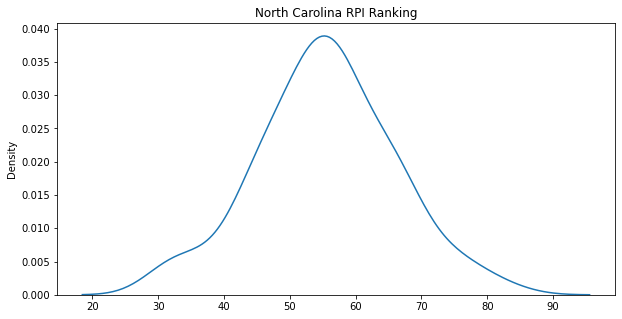

21.0


In [98]:
sn.kdeplot(data=y_ex_est,bw_adjust=1) 
plt.title(X_College_2019[X_ex.index].iloc[0] + ' RPI Ranking')
plt.show()
print(y_ex)

In [78]:
n_bootstrap = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

idx_ex = 20
y_ex = y_test.iloc[idx_ex]
X_ex = pd.DataFrame(X_test.iloc[[idx_ex]])
y_ex_est = []
boostrap_models = list()
for i_b in range(n_bootstrap):
    idx_resample =  resample(range(len(y_train)), replace=True, n_samples=len(y_train))
    X_i = X_train.iloc[idx_resample]
    y_i = y_train.iloc[idx_resample]
    bootstrap_models = bootstrap_models.append(best_xgbmodel.fit(X_i,y_i))
    #y_ex_est = np.append(y_ex_est,int(best_xgbmodel.predict(X_ex)))

NameError: name 'bootstrap_models' is not defined

In [81]:


object_pi = math.pi 
file_pi = open('filename_pi.obj', 'w') 
pickle.dump(object_pi, file_pi)

TypeError: 'XGBRegressor' object is not iterable

In [101]:
X_College_2019

0                  Oklahoma
1                      UCLA
2                Washington
3                   Arizona
4             Florida State
               ...         
292         Ark.-Pine Bluff
293                    UMES
294             Southern U.
295           Saint Peter's
296    South Carolina State
Name: College, Length: 297, dtype: object